# Recursive Descent Parser

## Grammar

```bash
E  → T (("+" | "-") T)*         # Expression: one or more terms combined with + or -
T  → F (("*" | "/") F)*         # Term: one or more factors combined with * or /
F  → "(" E ")" | D+             # Factor: a parenthesized expression or a sequence of digits
D  → "0" | "1" | "2" | ... | "9"  # Digit: A single numeric digit (0-9)
```


## Code

In [10]:
import re
import graphviz
from IPython.display import display
from PIL import Image
from io import BytesIO

In [15]:
# Tokenizer
TOKEN_PATTERN = re.compile(r"\d+|\+|\-|\*|\/|\(|\)")
    
class Tokenizer:
    def __init__(self, expression):
        self.tokens = TOKEN_PATTERN.findall(expression)
        self.index = 0

    def get_next_token(self):
        if self.index < len(self.tokens):
            token = self.tokens[self.index]
            self.index += 1
            return token
        return None

    def peek(self):
        return self.tokens[self.index] if self.index < len(self.tokens) else None

In [16]:
# AST Node
class ASTNode:
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

In [17]:
# Recursive Descent Parser
class Parser:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.current_token = self.tokenizer.get_next_token()

    def eat(self, expected_token):
        if self.current_token == expected_token:
            self.current_token = self.tokenizer.get_next_token()
        else:
            raise SyntaxError(f"Expected {expected_token}, got {self.current_token}")

    def parse_expression(self):
        node = self.parse_term()
        while self.current_token in ('+', '-'):
            op = self.current_token
            self.eat(op)
            node = ASTNode(op, left=node, right=self.parse_term())
        return node

    def parse_term(self):
        node = self.parse_factor()
        while self.current_token in ('*', '/'):
            op = self.current_token
            self.eat(op)
            node = ASTNode(op, left=node, right=self.parse_factor())
        return node

    def parse_factor(self):
        token = self.current_token
        if token.isdigit():
            self.eat(token)
            return ASTNode(token)
        elif token == '(':
            self.eat('(')
            node = self.parse_expression()
            self.eat(')')
            return node
        else:
            raise SyntaxError(f"Unexpected token: {token}")


In [18]:
# AST Visualization using Graphviz
def visualize_ast(node, graph=None, parent=None, node_id=0):
    """ Recursively generate a Graphviz Digraph for the AST """
    if graph is None:
        graph = graphviz.Digraph(format='png')

    current_id = str(node_id)
    graph.node(current_id, node.value)

    if parent is not None:
        graph.edge(parent, current_id)

    next_id = node_id + 1  # Increment ID for the next nodes
    if node.left:
        visualize_ast(node.left, graph, current_id, next_id)
        next_id += 1  # Ensure unique IDs
    if node.right:
        visualize_ast(node.right, graph, current_id, next_id)

    return graph  # Return the Digraph, not an integer

## Usage

In [22]:
# Example usage
expression = "3 + 5 * (2 - 8)"
tokenizer = Tokenizer(expression)
parser = Parser(tokenizer)
ast = parser.parse_expression()

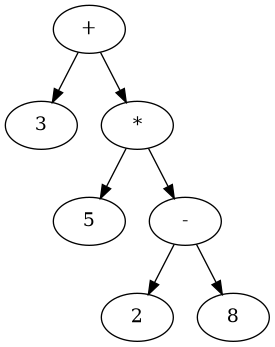

In [23]:
# Generate AST Graph
graph = visualize_ast(ast)

# Display in Jupyter Notebook
img = Image.open(BytesIO(graph.pipe(format='png')))
display(img)